In [1]:
%load_ext autoreload
%autoreload 2

In [529]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
import glob
import re
from io import StringIO, BytesIO
from functools import partial
from typing import Tuple

import h5py
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import xml.etree.ElementTree as ET
import trimesh
import trimesh.transformations as tt
from scipy.spatial import cKDTree
from scipy import interpolate

In [647]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.data.datasets.sharpf_io as sharpf_io
import sharpf.utils.abc_utils.hdf5.io_struct as io
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose
from sharpf.utils.py_utils.console import eprint_t

In [519]:
def _a(arr): return np.asanyarray(arr)
def _r(arr): return np.asanyarray(arr)[::-1]

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

DISPLAY_RES = 0.03

In [6]:
UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')

In [7]:
!ls /logs/whole_models_inference_final/predictions/images/real_world_high/0.005/resnet152/regression/blade.ply__11.2mm

predictions  tb_logs  train_net.log


In [8]:
d = '/logs/whole_models_inference_final/predictions/images/real_world_high/0.005/resnet152/regression/blade.ply__11.2mm/predictions/'
pred_images = []
for f in glob.glob(d + '/*.npy'):
    pred_images.append(np.load(f))

In [ ]:
display_depth_sharpness(
    sharpness_images=[pred_images[0]],
    axes_size=(16, 16*4),
    ncols=1
)

In [ ]:
PointPatchPredictionsIO = io.HDF5IO(
        {'distances': io.Float64('distances')},
        len_label='distances',
        compression='lzf')

predictions_dataset = Hdf5File(
    predictions_filename,
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

# pred_images_distances = [patch['distances'] for patch in predictions_dataset]

# pred_images_distances_masked = []
# for image, distances in zip(gt_images, pred_images_distances):
#     distances_masked = np.zeros_like(distances)
#     distances_masked[image == 0.] = 0.
#     distances_masked[image != 0.] = distances[image != 0.]
#     pred_images_distances_masked.append(distances_masked)

In [9]:
UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')

In [24]:
base_groundtruth_dir = '/data/abc/sharp_features_whole_models'

base_predictions_dir = '/logs/whole_models_inference_final'

obj_name = '20201112_40cm_big'

## Display whole model without predictions 

In [25]:
ground_truth_filename = os.path.join(base_groundtruth_dir, obj_name, obj_name + '.hdf5')
ground_truth_dataset = Hdf5File(
    ground_truth_filename,
    io=UnlabeledSLDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

ground_truth = [view for view in ground_truth_dataset]
gt_images = [view['image'] for view in ground_truth]
gt_distances = [view.get('distances', np.ones_like(view['image'])) for view in ground_truth]
gt_extrinsics = [view['camera_extrinsics'] for view in ground_truth]
gt_intrinsics_f = [view['camera_intrinsics_f'] for view in ground_truth]
gt_intrinsics_s = [view['camera_intrinsics_s'] for view in ground_truth]
gt_offsets = [view['image_offset'] for view in ground_truth]
gt_items = [view['item_id'].decode() for view in ground_truth]

File /data/abc/sharp_features_whole_models/20201112_40cm_big/20201112_40cm_big.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /data/abc/sharp_features_whole_models/20201112_40cm_big/20201112_40cm_big.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


/code/sharpf/utils/plotting.py:185: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  depth_cmap.set_bad(color='black')


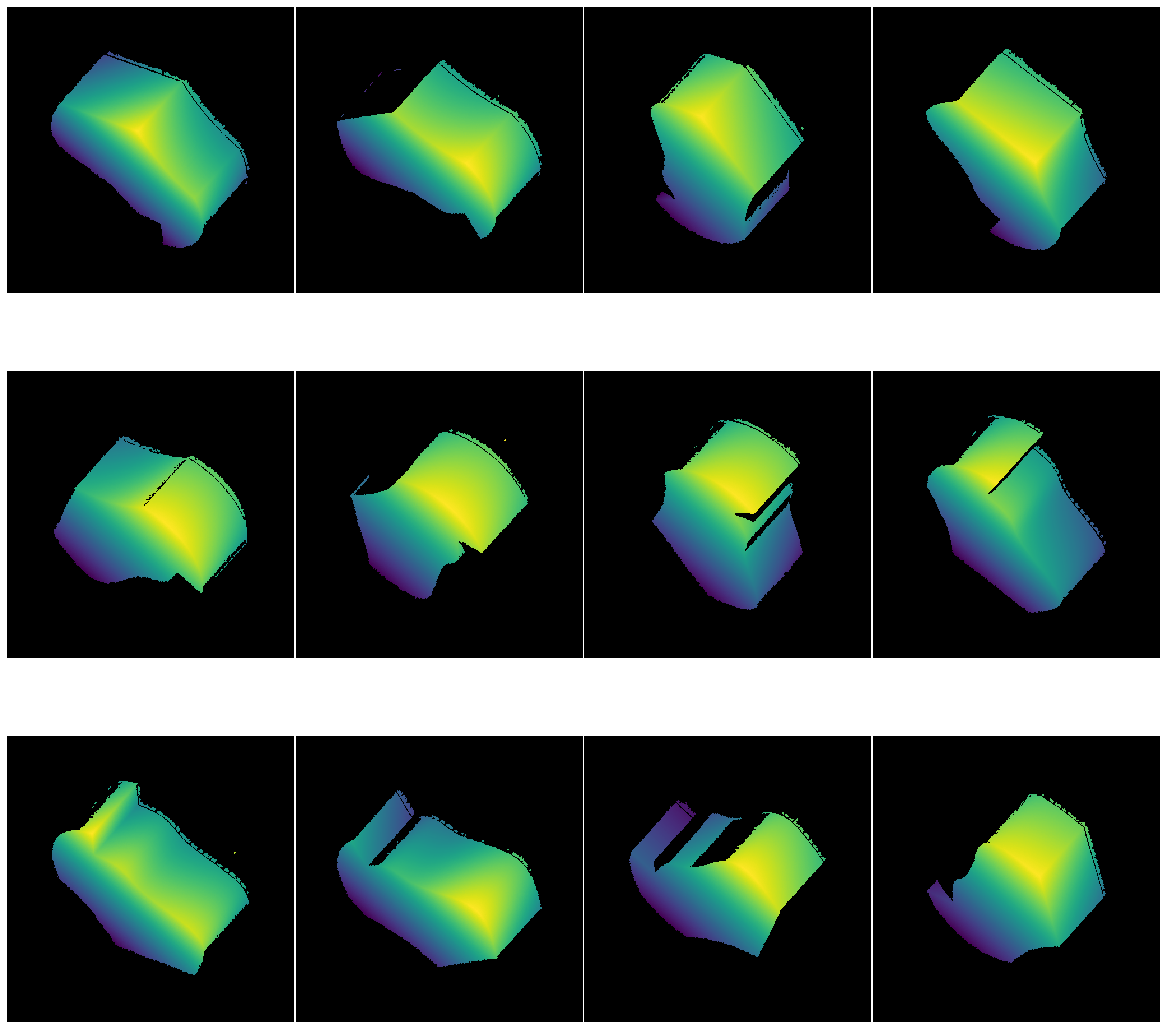

In [26]:
display_depth_sharpness(
    depth_images=gt_images,
    axes_size=(16, 16),
    ncols=4
)

In [27]:
with open('/code/scripts/data_scripts/configs/depthmap_datasets/high_res_whole.json') as config_file:
    config = json.load(config_file)
    config['imaging']['resolution_image'] = gt_images[0].shape[0]
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
# print(imaging.resolution_image, gt_images[0].shape)



In [28]:
def convert_npylist_to_hdf5(input_dir, output_filename):
    PointPatchPredictionsIO = io.HDF5IO(
        {'distances': io.Float64('distances')},
        len_label='distances',
        compression='lzf')

    def save_predictions(patches, filename):
        collate_fn = partial(io.collate_mapping_with_io, io=PointPatchPredictionsIO)
        patches = collate_fn(patches)
        with h5py.File(filename, 'w') as f:
            PointPatchPredictionsIO.write(f, 'distances', patches['distances'])

    def get_num(basename):
        match = re.match('^test_(\d+)\.npy$', basename)
        return int(match.groups()[0])

    datafiles = glob.glob(os.path.join(input_dir, '*.npy'))
    datafiles.sort(key=lambda name: get_num(os.path.basename(name)))
    patches = [{'distances': np.load(f)} for f in datafiles]
    save_predictions(patches, output_filename)

In [29]:
predictions_dir = os.path.join(
    base_predictions_dir,
    'predictions/images/sl_v2_high',
    '0.0/resnet152/regression',
    obj_name,
    'predictions'
)
predictions_filename = os.path.join(
    base_predictions_dir,
    'combined/images/sl_high',
    '0.0/resnet152/regression'
    '{}__{}.hdf5'.format(obj_name, 'predictions'))
os.makedirs(os.path.dirname(predictions_filename), exist_ok=True)

convert_npylist_to_hdf5(predictions_dir, predictions_filename)

In [30]:
PointPatchPredictionsIO = io.HDF5IO(
        {'distances': io.Float64('distances')},
        len_label='distances',
        compression='lzf')

predictions_dataset = Hdf5File(
    predictions_filename,
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_images_distances = [patch['distances'] for patch in predictions_dataset]

pred_images_distances_masked = []
for image, distances in zip(gt_images, pred_images_distances):
    distances_masked = np.zeros_like(distances)
    distances_masked[image == 0.] = 0.
    distances_masked[image != 0.] = distances[image != 0.]
    pred_images_distances_masked.append(distances_masked)

/code/sharpf/utils/plotting.py:201: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm_r"))
  sharpness_cmap.set_bad(color='black')


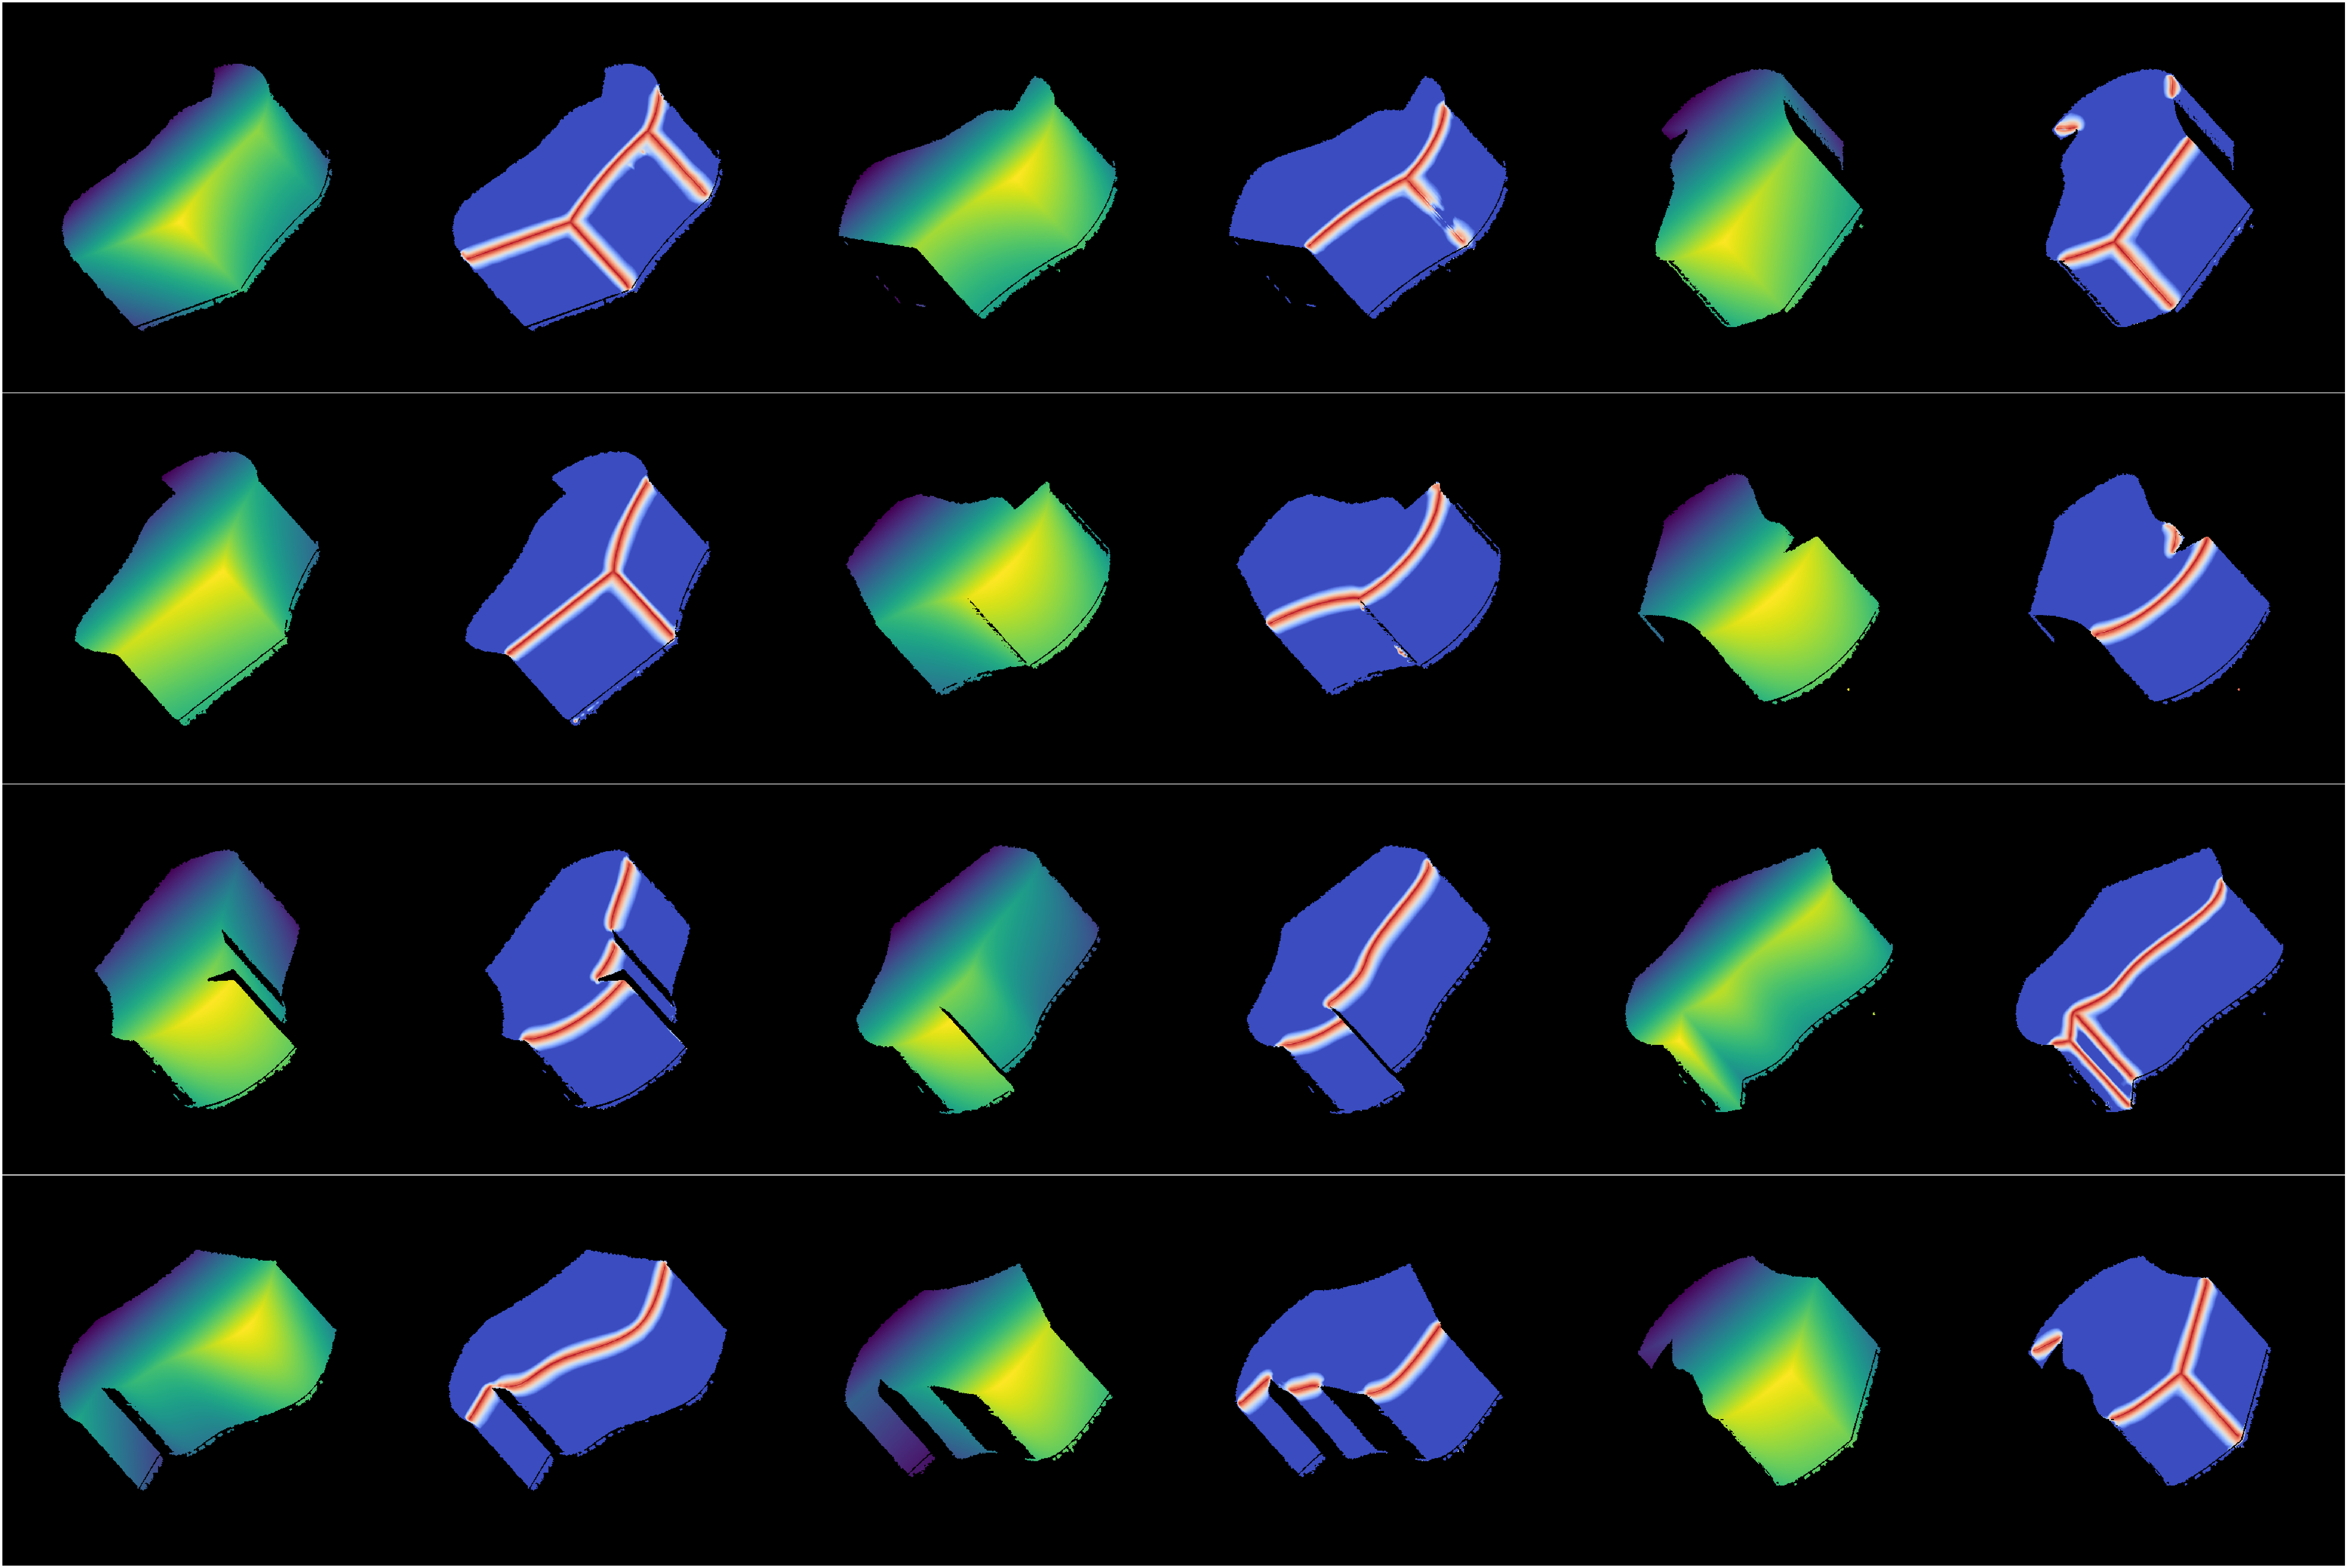

In [31]:
display_depth_sharpness(
    depth_images=[i[::-1] for i in gt_images],
    sharpness_images=[i[::-1] for i in pred_images_distances_masked],
    axes_size=(16, 16),
    ncols=3
)

In [32]:
def load_scans(base_dir):
    matlab_project_filename = glob.glob(os.path.join(base_dir, '*.mlp'))[0]
    root = ET.parse(matlab_project_filename).getroot()

    filenames = []
    points_by_scan = []
    transform_by_scan_4x4 = []

    item_id = None
    for type_tag in root.findall('MeshGroup/MLMesh'):
        filename = type_tag.get('filename')
        
        print(filename)
        if filename.endswith('.obj'):
            item_id = filename

        elif filename.endswith('.ply'):
            try:
                transform = np.loadtxt(
                    StringIO(type_tag.find('MLMatrix44').text))
                points = trimesh.load(os.path.join(base_dir, filename)).vertices
            except ValueError as e:
                continue
            
            transform_by_scan_4x4.append(transform)
            points_by_scan.append(points)
            filenames.append(filename)
            
    return filenames, points_by_scan, transform_by_scan_4x4, item_id

In [34]:
filenames, points_by_scan, transform_by_scan_4x4, item_id = \
    load_scans(os.path.join(base_groundtruth_dir, obj_name + '_registered'))


00500041_5aa40dcd43fa0b14df9bdcf8_trimesh_010.obj
20201112_40cm_Big 0.ply
20201112_40cm_Big 1.ply
20201112_40cm_Big 2.ply
20201112_40cm_Big 6.ply
20201112_40cm_Big 8.ply
20201112_40cm_Big 9.ply
20201112_40cm_Big 11.ply


In [36]:
idx = 0
image = gt_images[idx]
yy, xx = np.where(image)
image_crop = image[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]

pose = CameraPose(gt_extrinsics[idx])
Kf = gt_intrinsics_f[idx]
Ks = gt_intrinsics_s[idx]
image_offset = gt_offsets[idx]

In [37]:
x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(
    image_crop,
    pose,
    Kf, 
    Ks,
    image_offset
)

In [38]:
display_sharpness(
    samples=X_re,
    samples_distances=pred_images_distances_masked[idx][pred_images_distances_masked[idx] != 0.0].ravel(),
    samples_psize=0.4
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [39]:
gt_idx_by_filename = {
    filename: [idx for idx, item_id in enumerate(gt_items) if item_id.endswith(filename)][0]
    for filename in filenames
}
gt_idx_by_filename

{'20201112_40cm_Big 0.ply': 0,
 '20201112_40cm_Big 1.ply': 1,
 '20201112_40cm_Big 2.ply': 4,
 '20201112_40cm_Big 6.ply': 8,
 '20201112_40cm_Big 8.ply': 10,
 '20201112_40cm_Big 9.ply': 11,
 '20201112_40cm_Big 11.ply': 3}

In [40]:
transforms = []
for item_id in gt_items:
    found = False
    for filename, transform in zip(filenames, transform_by_scan_4x4):
        if item_id.endswith(filename):
            transforms.append(transform)
            found = True
            break
    if not found:
        transforms.append(None)

In [41]:
whole_model_points_gt = []

for filename, scanned_points, transform in zip(filenames, points_by_scan, transform_by_scan_4x4):
    idx = gt_idx_by_filename[filename]
    
    image = gt_images[idx]
    yy, xx = np.where(image)
    image_crop = image[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]

    pose = CameraPose(gt_extrinsics[idx])
    Kf = gt_intrinsics_f[idx]
    Ks = gt_intrinsics_s[idx]
    image_offset = gt_offsets[idx]

    x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(
        image_crop,
        pose,
        Kf, 
        Ks,
        image_offset
    )

#     points = X_re
    points = tt.transform_points(X_re, transform, translate=True)
    whole_model_points_gt.append(points)

In [42]:
whole_model_points_gt = np.concatenate(whole_model_points_gt)

In [43]:
display_sharpness(
    samples=whole_model_points_gt,
#     samples_distances=pred_images_distances_masked[idx][pred_images_distances_masked[idx] != 0.0].ravel(),
    samples_psize=0.4
)

Output()

In [44]:
gt_idx_by_filename

{'20201112_40cm_Big 0.ply': 0,
 '20201112_40cm_Big 1.ply': 1,
 '20201112_40cm_Big 2.ply': 4,
 '20201112_40cm_Big 6.ply': 8,
 '20201112_40cm_Big 8.ply': 10,
 '20201112_40cm_Big 9.ply': 11,
 '20201112_40cm_Big 11.ply': 3}

In [754]:
def data_crop(image):
    yy, xx = np.where(image)
    return image[
        np.min(yy):np.max(yy) + 1,
        np.min(xx):np.max(xx) + 1]


def uncrop_offset(image, offset, image_size=None):
    if None is image_size:
        image_size = (
            image.shape[0] + offset[1],
            image.shape[1] + offset[0])
    uncropped = np.zeros(image_size)
    uncropped[
        offset[1]:offset[1] + image.shape[0],
        offset[0]:offset[0] + image.shape[1],
    ] = image
    return uncropped


In [780]:
def get_view(i):
    # use exterior variables
    pose_i = CameraPose(gt_extrinsics[i])
    Kf_i, Ks_i = gt_intrinsics_f[i], gt_intrinsics_s[i]
    offset_i = gt_offsets[i].astype(int)
    image_i = gt_images[i]

    image_crop_i = data_crop(image_i)#[1:, :-1]
#     yy, xx = np.where(image_i)
#     image_crop = image_i[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]
    _, _, _, points_i = reproject_image_to_points(
        image_crop_i, pose_i, Kf_i, Ks_i, offset_i)
    
    transform_i = transforms[i]
    assert None is not transform_i
    points_i = tt.transform_points(points_i, transform_i, translate=True)

    predictions_i = np.zeros_like(image_i)
    predictions_i[image_i != 0.] = pred_images_distances_masked[i][image_i != 0.]
    return (transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i



In [1021]:
def assign_by_min_depth(
    image_size,
    image_offset,
    x_pixel: np.ndarray,
    depth: np.ndarray,
    func=np.min
):
    """Given a [n, 3] array of rounded pixel coordinates (indexes) 
    and corresponding [n,] array of depth values,
    return a 2d image with pixel values assigned to smallest (closest to camera) depth values.

    Normally we do:
    >>> image = np.zeros((image_size[1], image_size[0]))
    >>> image[
    >>>     x_pixel[:, 1] - image_offset[1],
    >>>     x_pixel[:, 0] - image_offset[0]] = depth
    
    However, if multiple values in x_pixel index into the same (x, y) pixel in image,
    i.e. for i != j we have x_pixel[i] == x_pixel[j],
    we end up assigning arbitrary depth value in image.
    
    Instead we do (conceptually):
    >>> image[x_pixel] = func(depth[i] for i where x_pixel[i] == c)
    """
    
    # sort XY array by row/col index
    sort_idx_1 = x_pixel[:,1].argsort()
    x_pixel = x_pixel[sort_idx_1]
    sort_idx_0 = x_pixel[:, 0].argsort(kind='mergesort')
    x_pixel = x_pixel[sort_idx_0]

    idx_sort = sort_idx_1[sort_idx_0]

    # returns the unique values, the index of the first occurrence of a value, and the count for each element
    vals, idx_start, count = np.unique(x_pixel, axis=0, return_counts=True, return_index=True)
    
    # splits the indices into separate arrays
    res = np.split(idx_sort, idx_start[1:])

    image = np.zeros((image_size[1], image_size[0]))
    for pixel_xy, idx_arr in zip(vals, res):
        image[
            pixel_xy[1] - image_offset[1],
            pixel_xy[0] - image_offset[0]] = func(depth[idx_arr])
    
    return x_pixel, image

In [1022]:
def project_to_camera(
        points,
        pose: CameraPose,
        Kf: np.array,
        Ks: np.array,
        image_size: Tuple[int, int],
):
    X_world = points

    # transform to camera frame
    X_camera = pose.world_to_camera(X_world)

    # project using perspective projection
    x_image = np.dot(Kf, X_camera.T).T

    # separate XY (image coordinates) and Z
    x_image_saved = x_image.copy()
    depth = x_image[:, 2].copy()
    x_image[:, 2] = 1.

    # obtain XY in pixel coordinates
    x_pixel = np.dot(Ks, x_image.T).T
    x_pixel = np.round(x_pixel).astype(np.int32)

    # construct image
    image_offset = np.min(x_pixel, axis=0)[:2]
    image_size = np.max(x_pixel, axis=0) - np.min(x_pixel, axis=0) + 1
    print('Overwriting image_size with ', (image_size[1], image_size[0]))

    x_pixel, image = assign_by_min_depth(
        image_size, image_offset, x_pixel, depth, func=np.max)

#     image = np.zeros((image_size[1], image_size[0]))
#     image[
#         x_pixel[:, 1] - image_offset[1],
#         x_pixel[:, 0] - image_offset[0]] = depth

    # image = np.zeros((image_size[1] + 1, image_size[0] + 1))
    # image[x_pixel[:, 1], x_pixel[:, 0]] = depth

    return X_camera, x_pixel, x_image_saved, image, (image_offset[0], image_offset[1])



def reproject_image_to_points(
    image,
    pose: CameraPose,
    Kf: np.array,
    Ks: np.array,
    image_offset: Tuple[int, int],
):
    image_size = (
        image.shape[1] + image_offset[0], 
        image.shape[0] + image_offset[1])

#     x_mm = np.linspace(0, 2048 / s_x, 2048)
#     y_mm = np.linspace(0, 1536 / s_y, 1536)
    i = np.arange(image_offset[0], image_offset[0] + image.shape[1])
    j = np.arange(image_offset[1], image_offset[1] + image.shape[0])
    i, j = np.meshgrid(i, j)
    
    x_pixel = np.stack((i, j, np.ones_like(i))) #.reshape((3, -1)).T
    x_pixel = x_pixel[:, image != 0].T
    
    x_image = np.dot(
        np.linalg.inv(Ks),
        x_pixel.T).T
    x_image[:, 2] = image[image != 0].ravel()

    X_camera = np.dot(
        np.linalg.inv(Kf),
        x_image.T).T
    
    X = pose.camera_to_world(X_camera)
    
    return x_pixel, x_image, X_camera, X

In [1023]:
(transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i = get_view(0)

In [1024]:
(transform_j, pose_j, Kf_j, Ks_j, offset_j), image_j, points_j, predictions_j = get_view(4)

In [1025]:
_, _, x_image_reprojected_i, reprojected_i, reprojected_offset_i = project_to_camera(
    tt.transform_points(points_i, np.linalg.inv(transform_i)),
    pose_i,
    Kf_i,
    Ks_i,
    image_size=(512, 512),
)

Overwriting image_size with  (351, 355)


In [1026]:
_, _, x_image_reprojected_j, reprojected_j, reprojected_offset_j = project_to_camera(
    tt.transform_points(points_j, np.linalg.inv(transform_i)),
    pose_i,
    Kf_i,
    Ks_i,
    image_size=(512, 512),
)

Overwriting image_size with  (296, 357)


In [1027]:
_, _, _, points_j_reconstructed = reproject_image_to_points(
    reprojected_j,
    pose_i,
    Kf_i,
    Ks_i,
    reprojected_offset_j
)
_, _, _, points_i_reconstructed = reproject_image_to_points(
    reprojected_i,
    pose_i,
    Kf_i,
    Ks_i,
    reprojected_offset_i
)

In [1060]:
#         (tt.transform_points(points_j, np.linalg.inv(transform_i)),
#          tt.transform_points(points_i, np.linalg.inv(transform_i))

display_sharpness(
    samples=\
    np.concatenate(
        (
         points_i_reconstructed, points_j_reconstructed
        )),
#     samples_distances=pred_images_distances_masked[idx][pred_images_distances_masked[idx] != 0.0].ravel(),
    samples_psize=0.1,
    samples_color=0x6666ff
)

# display_sharpness(
#     samples=points_i,
#     samples_distances=predictions_i[predictions_i != 0].ravel(),
#     samples_psize=0.1
# )

Output()

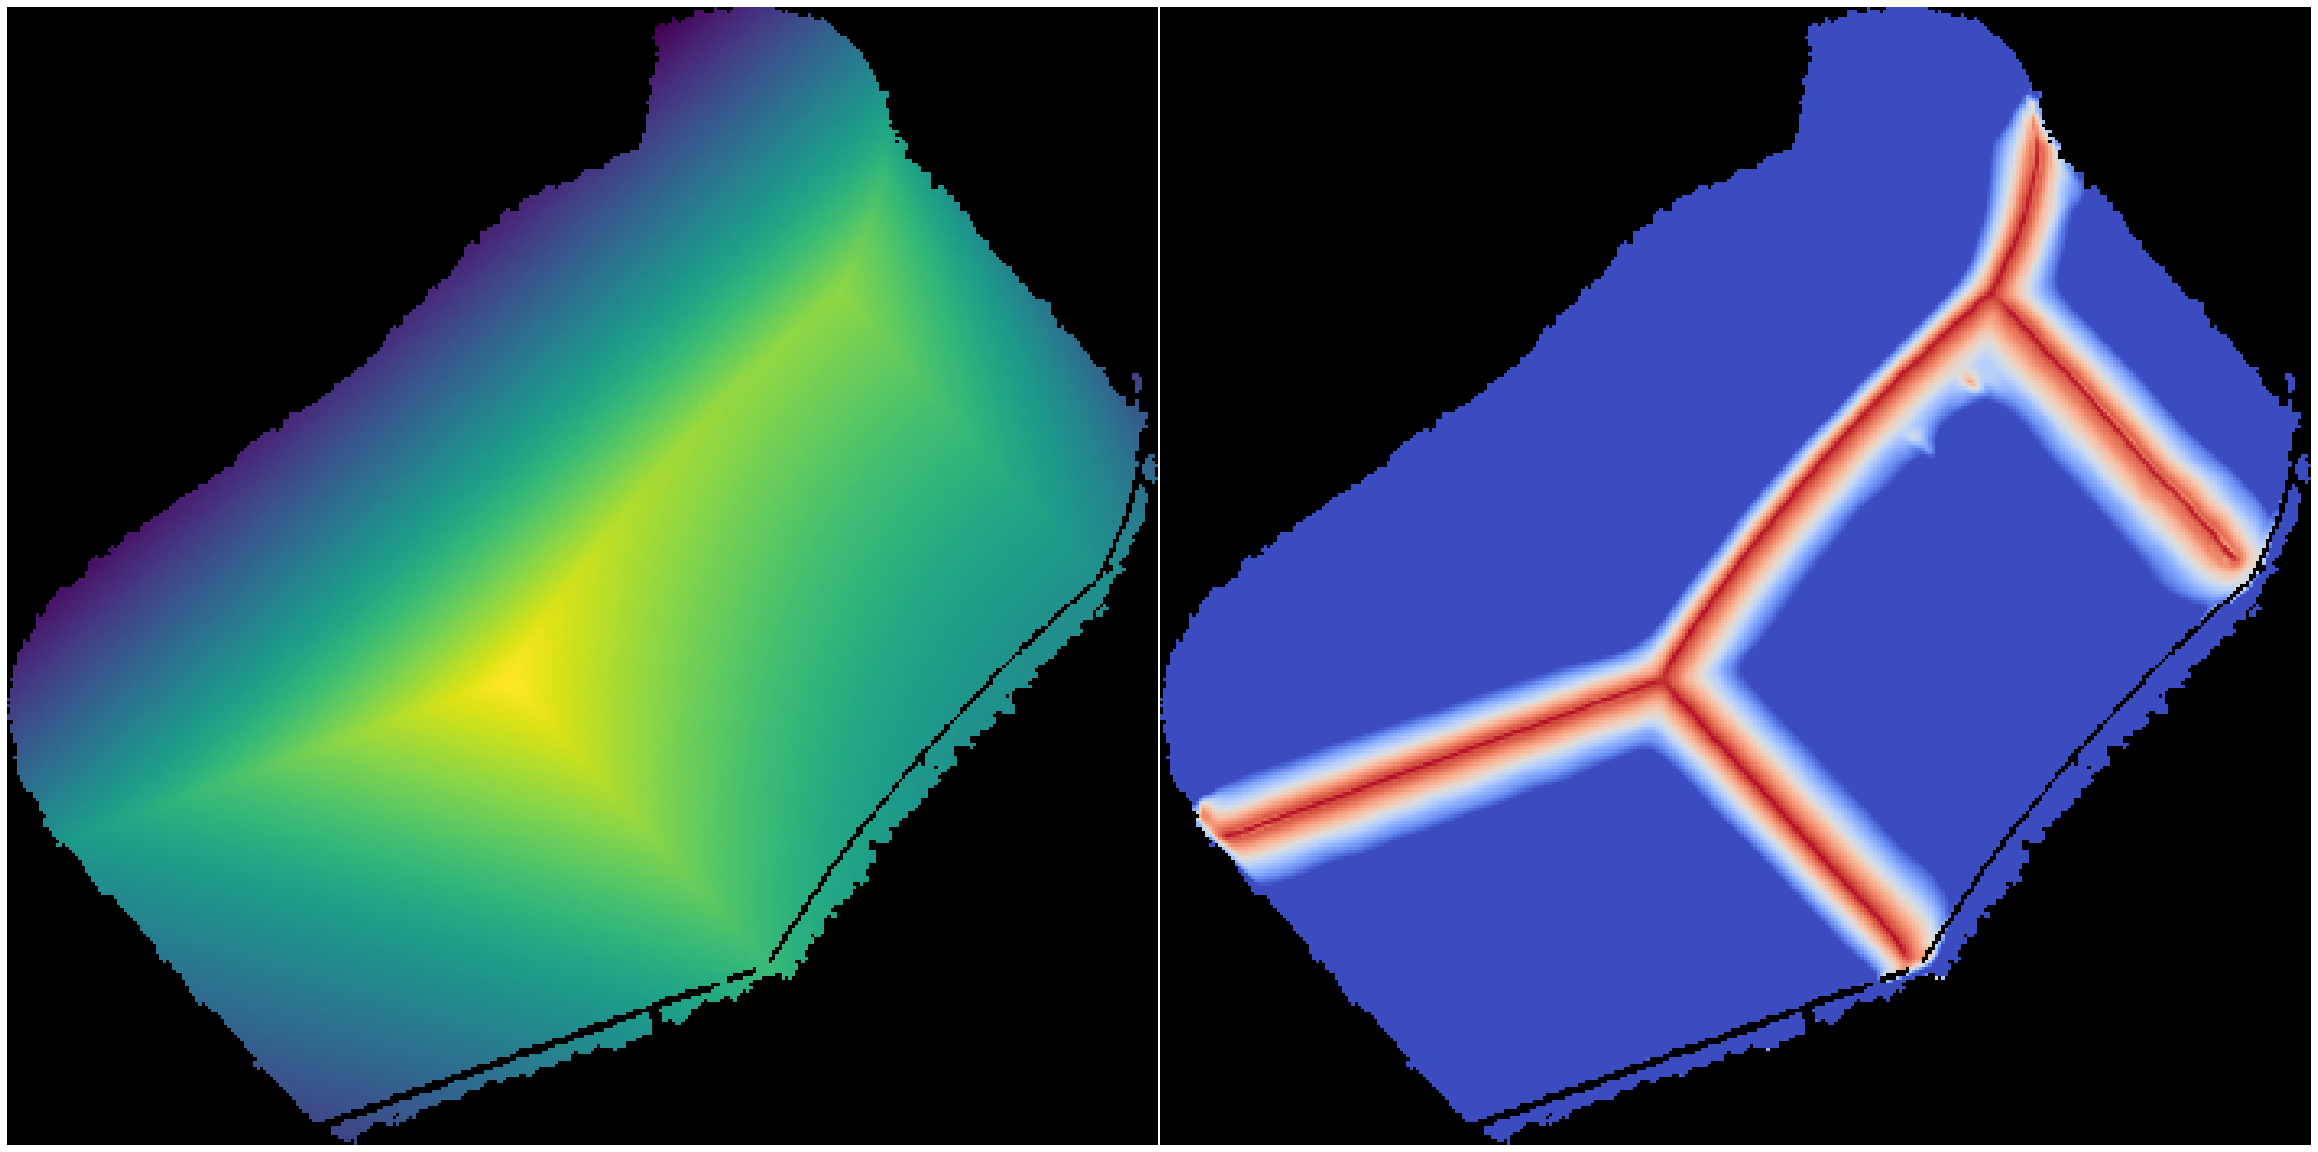

In [1031]:
display_depth_sharpness(
    reprojected_i[::-1],
    data_crop(predictions_i)[::-1],
    axes_size=(16,16),
    ncols=1)

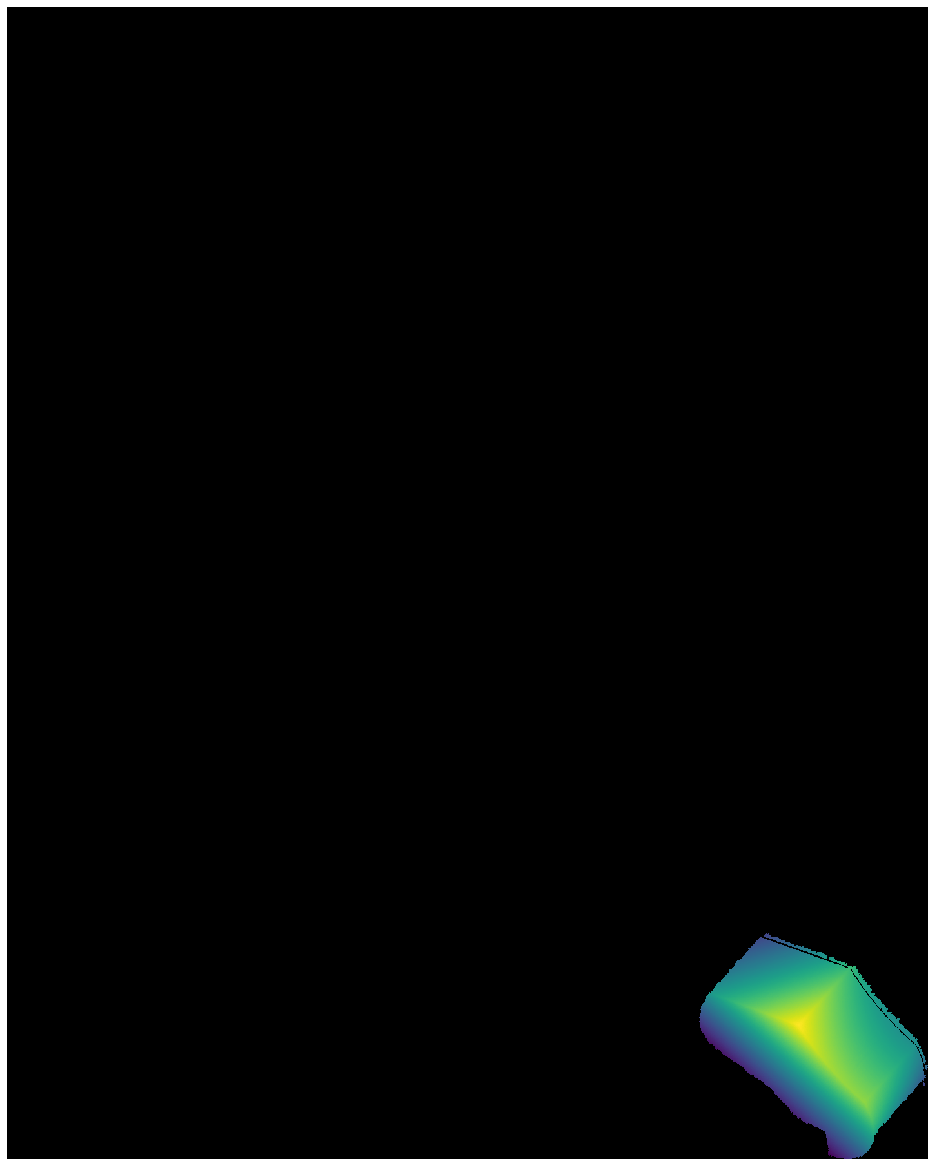

In [1032]:
display_depth_sharpness(
    uncrop_offset(reprojected_i, reprojected_offset_i),
    axes_size=(16,16),
    ncols=1)

In [1033]:
def images_to_shared_pixel_space(
    image_0, 
    image_1,
    offset_0,
    offset_1,
):
    """Given two images (data-cropped, cf. data_crop above) and their offsets from (0, 0), 
    produce two padded (nearly data-cropped) images with same size, and their (equal) offsets. """

    image_size_0 = (
        image_0.shape[0] + offset_0[1],
        image_0.shape[1] + offset_0[0])

    image_size_1 = (
        image_1.shape[0] + offset_1[1],
        image_1.shape[1] + offset_1[0])

    image_size = np.maximum(image_size_0, image_size_1)
    offset = np.minimum(offset_0, offset_1)

    uncropped_0 = uncrop_offset(image_0, offset_0, image_size)
    uncropped_1 = uncrop_offset(image_1, offset_1, image_size)
    
    aligned_0 = uncropped_0[offset[1]:, offset[0]:]
    aligned_1 = uncropped_1[offset[1]:, offset[0]:]
    
    return aligned_0, aligned_1, offset, offset

In [1034]:
aligned_i, aligned_j, aligned_offset_i, aligned_offset_j = \
    images_to_shared_pixel_space(reprojected_i, reprojected_j, reprojected_offset_i, reprojected_offset_j)

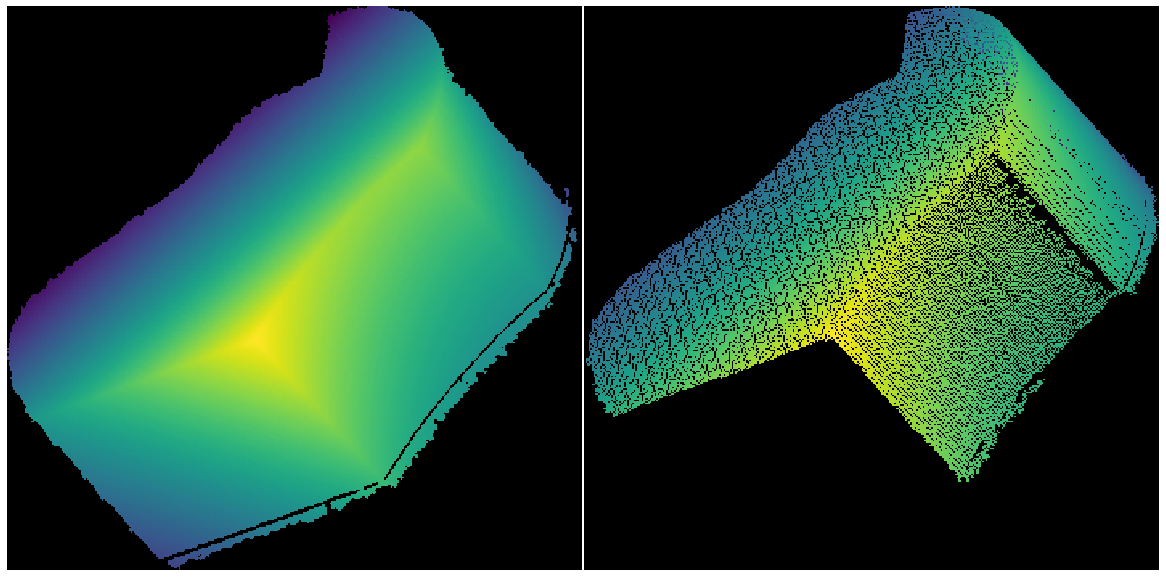

In [1035]:
display_depth_sharpness([
    aligned_i[::-1],
    aligned_j[::-1]
], 
axes_size=(16, 16),
ncols=2)

In [1036]:
aligned_predictions_i = \
    uncrop_offset(
        data_crop(predictions_i),
        aligned_offset_i, 
        _a(aligned_i.shape) + _r(aligned_offset_i)
    )[aligned_offset_i[1]:, aligned_offset_i[0]:]

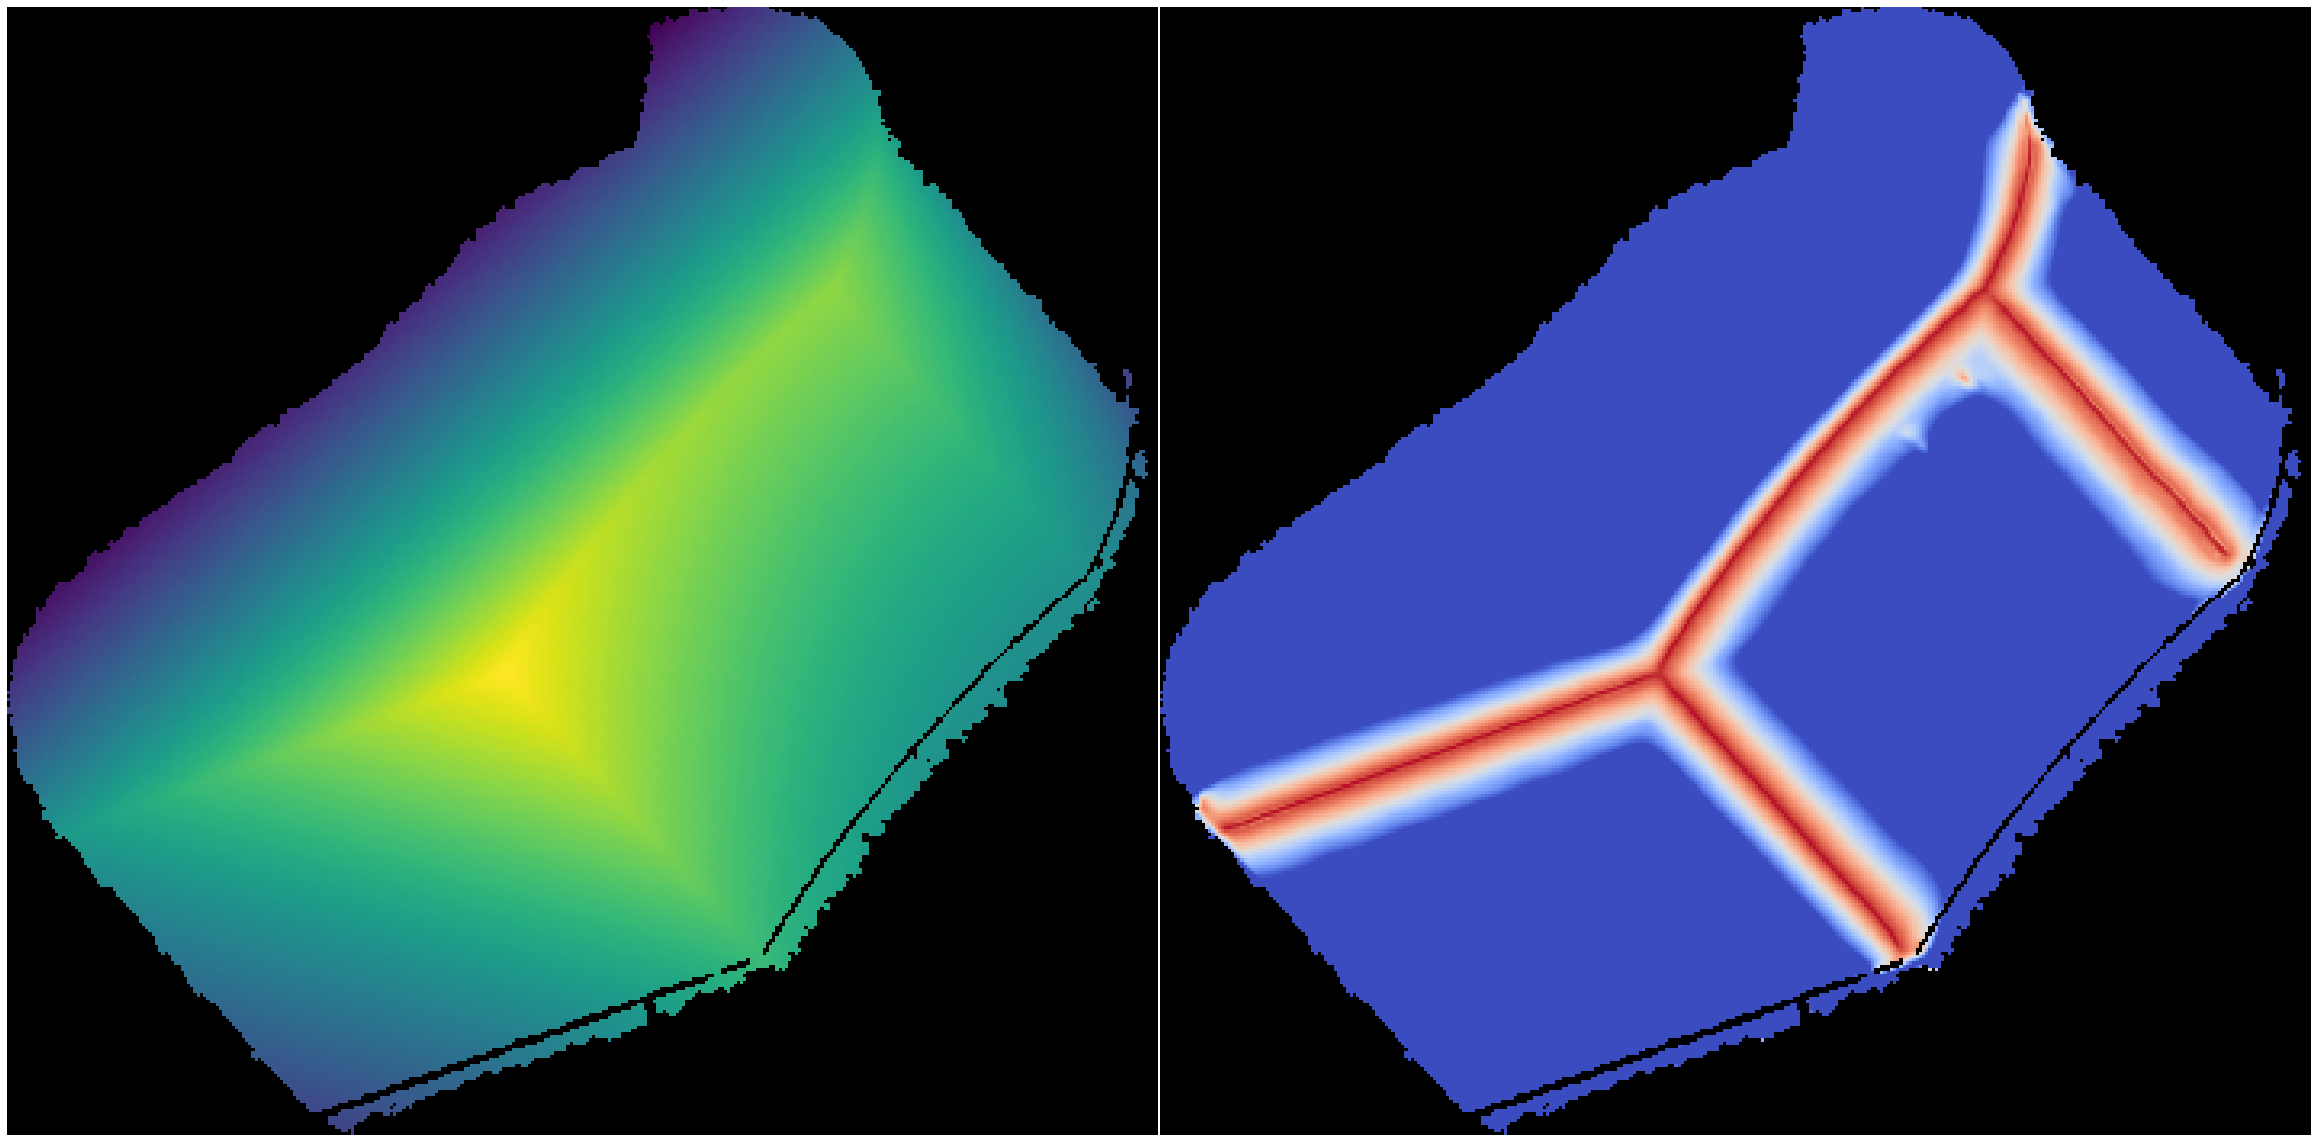

In [1037]:
display_depth_sharpness(
    depth_images=[aligned_i[::-1]], 
    sharpness_images=[aligned_predictions_i[::-1]], 
axes_size=(16, 16),
ncols=1)

In [1038]:
def pixel_nbhood_nxn(image, p, n=1, zval=0.0):
    """Selects all nonzero pixels in the n * n neighbourhood of point p."""
    x, y = p
    min_x, max_x = max(0, x - n), min(x + n + 1, image.shape[1])
    min_y, max_y = max(0, y - n), min(y + n + 1, image.shape[0])
    xs, ys = np.arange(min_x, max_x), np.arange(min_y, max_y)
    xs, ys = np.meshgrid(xs, ys)
    nonzero_y, nonzero_x = np.where(image[ys, xs] != zval)
    return xs[nonzero_y, nonzero_x], ys[nonzero_y, nonzero_x], image[ys, xs][nonzero_y, nonzero_x]

In [1044]:
def pixelwise_bilinear_interpolate(
    source_image,
    source_signal,
    target_image,
    min_values_to_interpolate=6,
    distance_interpolation_threshold=0.1 * 6.
):
    """Given a pair of registered images `source_image` and `target_image`
    and a registered `source_signal` image (defined on `source_image`),
    compute `target_signal` as a bilinear interpolation of source signal
    onto pixels of `target_image`."""

    nz_y, nz_x = np.where(target_image)
    target_signal = np.zeros_like(target_image)

    for x, y in tqdm(zip(nz_x, nz_y), total=len(nz_x)):
        xs, ys, zs = pixel_nbhood_nxn(source_image, (x, y), n=1)
        xs, ys, ds = pixel_nbhood_nxn(source_signal, (x, y), n=1)

        close_mask = np.abs(target_image[y, x] - zs) < distance_interpolation_threshold
        xs, ys, ds = xs[close_mask], ys[close_mask], ds[close_mask]

        if len(ds) < min_values_to_interpolate:
            continue

        try:
            interpolator = interpolate.interp2d(
                xs, ys, ds,
                kind='linear',
                bounds_error=True)
            target_signal[y, x] = interpolator(x, y)[0]
        except ValueError as e:
            eprint_t('Error while interpolating at ({x}, {y}): {what}, skipping'.format(
                x=x, y=y, what=str(e)))

    return target_signal


In [1045]:
interpolated_predictions_j = pixelwise_bilinear_interpolate(
    aligned_i,
    aligned_predictions_i,
    aligned_j,
    min_values_to_interpolate = 6,
    distance_interpolation_threshold = 0.1 * 6.)

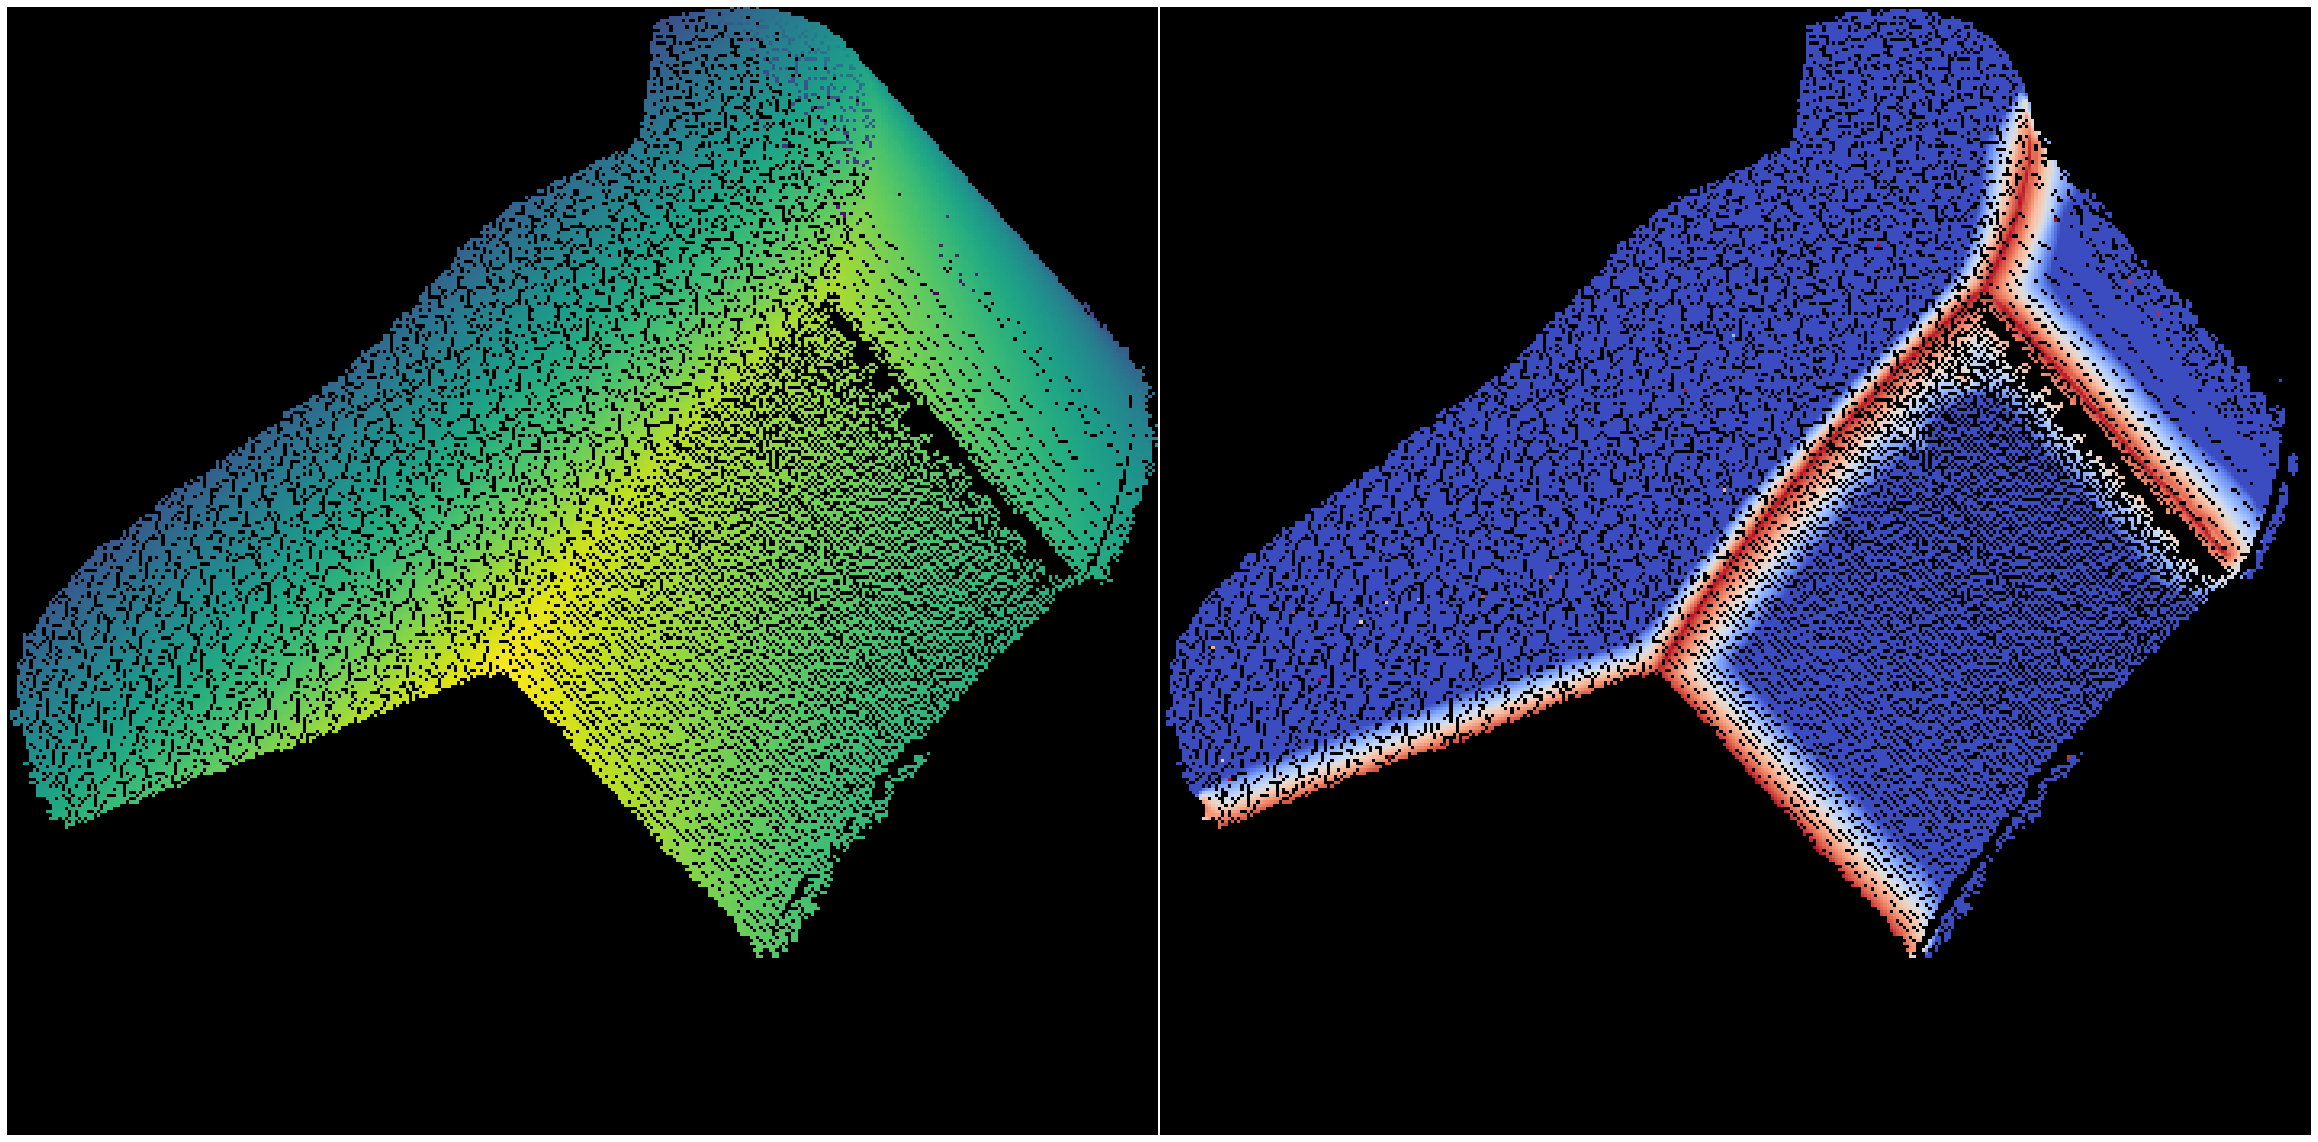

In [1046]:
display_depth_sharpness(
    depth_images=[aligned_j[::-1]], 
    sharpness_images=[interpolated_predictions_j[::-1]], 
axes_size=(16, 16),
ncols=1)

In [1056]:
from typing import Callable, List, Mapping, Tuple


def multi_view_interpolate_predictions(
    gt_extrinsics,
    gt_intrinsics_f,
    gt_intrinsics_s,
    gt_images: List[np.array],
    predictions: List[np.array],
    verbose: bool = False,
    distance_interpolation_threshold: float = 0.1 * 6.
):
    """Interpolates predictions between views."""
    
    def get_view(i):
        # use exterior variables
        pose_i = CameraPose(gt_extrinsics[i])
        Kf_i, Ks_i = gt_intrinsics_f[i], gt_intrinsics_s[i]
        offset_i = gt_offsets[i].astype(int)
        image_i = gt_images[i]

        image_crop_i = data_crop(image_i)
        _, _, _, points_i = reproject_image_to_points(
            image_crop_i, pose_i, Kf_i, Ks_i, offset_i)

        transform_i = transforms[i]
        assert None is not transform_i
        points_i = tt.transform_points(points_i, transform_i, translate=True)

        predictions_i = np.zeros_like(image_i)
        predictions_i[image_i != 0.] = predictions[i][image_i != 0.]
        return (transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i

    
    min_values_to_interpolate = 6

    list_predictions, list_indexes_in_whole, list_points = [], [], []

    n_images = len(gt_images)
    n_points_per_image = np.cumsum([len(np.nonzero(image.ravel())[0]) for image in gt_images])

    for i in range(n_images):
        # Propagating predictions from view i into all other views
        try:
            (transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i = get_view(i)
        except AssertionError:
            eprint_t('No transform available for view {}, skipping'.format(i))
            continue

        _, _, _, reprojected_i, reprojected_offset_i = project_to_camera(
            tt.transform_points(points_i, np.linalg.inv(transform_i)),
            pose_i,
            Kf_i,
            Ks_i,
            image_size=(512, 512))

        for j in range(n_images):
            start_idx, end_idx = (0, n_points_per_image[j]) if 0 == j \
                else (n_points_per_image[j - 1], n_points_per_image[j])
            indexes_in_whole = np.arange(start_idx, end_idx)

#             if verbose:
#                 eprint_t('Propagating views {} -> {}'.format(i, j))

#             if i == j:
#                 list_points.append(points_i)
#                 list_predictions.append(predictions_i[image_i != 0.].ravel())
#                 list_indexes_in_whole.append(indexes_in_whole)

#             else:
#                 try:
#                     (transform_j, pose_j, Kf_j, Ks_j, offset_j), image_j, points_j, predictions_j = get_view(j)
#                 except AssertionError:
#                     eprint_t('No transform available for view {}, skipping'.format(j))
#                     continue

#                 _, _, _, reprojected_j, reprojected_offset_j = project_to_camera(
#                     tt.transform_points(points_j, np.linalg.inv(transform_i)),
#                     pose_i,
#                     Kf_i,
#                     Ks_i,
#                     image_size=(512, 512))
        
#                 aligned_i, aligned_j, aligned_offset_i, aligned_offset_j = images_to_shared_pixel_space(
#                     reprojected_i, reprojected_j, reprojected_offset_i, reprojected_offset_j)

#                 aligned_predictions_i = \
#                     uncrop_offset(
#                         data_crop(predictions_i),
#                         aligned_offset_i, 
#                         _a(aligned_i.shape) + _r(aligned_offset_i)
#                     )[aligned_offset_i[1]:, aligned_offset_i[0]:]

#                 interpolated_predictions_j = pixelwise_bilinear_interpolate(
#                     aligned_i,
#                     aligned_predictions_i,
#                     aligned_j,
#                     min_values_to_interpolate = 6,
#                     distance_interpolation_threshold = 0.1 * 6.)

#                 list_points.append(points_j[can_interpolate])
#                 list_predictions.append(interpolated_distances_j[can_interpolate])
#                 list_indexes_in_whole.append(indexes_in_whole[can_interpolate])

    return list_predictions, list_indexes_in_whole, list_points


In [1055]:
multi_view_interpolate_predictions(
    gt_extrinsics,
    gt_intrinsics_f,
    gt_intrinsics_s,
    gt_images,
    pred_images_distances_masked,
    verbose=True,
    distance_interpolation_threshold=0.1 * 6.)

Overwriting image_size with  (351, 355)
Overwriting image_size with  (318, 365)


08.12.2020 11:18:04.017833  MainProcess No transform available for view 2, skipping


Overwriting image_size with  (360, 322)
Overwriting image_size with  (280, 347)


08.12.2020 11:18:05.339301  MainProcess No transform available for view 5, skipping
08.12.2020 11:18:05.348579  MainProcess No transform available for view 6, skipping
08.12.2020 11:18:05.358585  MainProcess No transform available for view 7, skipping


Overwriting image_size with  (347, 352)


08.12.2020 11:18:06.061093  MainProcess No transform available for view 9, skipping


Overwriting image_size with  (280, 352)
Overwriting image_size with  (301, 318)


([], [], [])

[array([[ 9.90714271e-01,  2.86911765e-02, -1.32898647e-01,
         -6.32670000e+01],
        [-8.37624126e-03,  9.88503814e-01,  1.50963731e-01,
         -9.40244000e+01],
        [ 1.35702147e-01, -1.48448732e-01,  9.79565159e-01,
          4.83965000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 9.90714271e-01,  2.86911765e-02, -1.32898647e-01,
         -6.32670000e+01],
        [-8.37624126e-03,  9.88503814e-01,  1.50963731e-01,
         -9.40244000e+01],
        [ 1.35702147e-01, -1.48448732e-01,  9.79565159e-01,
          4.83965000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 9.90714271e-01,  2.86911765e-02, -1.32898647e-01,
         -6.32670000e+01],
        [-8.37624126e-03,  9.88503814e-01,  1.50963731e-01,
         -9.40244000e+01],
        [ 1.35702147e-01, -1.48448732e-01,  9.79565159e-01,
          4.83965000e+02],
        [ 0.00000000e+00,  0.00000000e+